In [16]:
# Dependencies
import pandas as pd
import numpy as np

In [19]:
# Load data (FRED-MD)
df = pd.read_csv(
    '/home/js/macroeconvue/nowcasting/ML/data.csv',
    index_col='sasdate',
    parse_dates=True
)
# Normalize the dataframe
df = (df - df.mean()) / df.std()
# Dropna
df = df.dropna()
# Get the target variable
target = df['CPIAUCSL'].copy()
# Drop the target 
# df = df.drop(columns=['CPIAUCSL'])

In [20]:
from sklearn.decomposition import PCA

# Apply PCA to the data
pca = PCA(n_components=0.90)
pca.fit(df)
data = pca.transform(df)

In [21]:
# Prepare data for the LSTM

# Convert data into sequences
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12  # Have one year of context
X, y = create_sequences(data, target.values, time_steps)

# # Split into train and test
split = len(X) - 12 # Last quarter for test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [22]:
# Build the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout

# Create model
model = Sequential([
    LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])

# Compile and train
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, verbose=1)

# Evaluate
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/50


/home/js/macroeconvue/nowcasting/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9668
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1024
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0811
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0478
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0534
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0565
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0475
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0464
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0469
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0481
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0388
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0366
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0385
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0349
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0328
Epoch 16/50
12/12 ━━━━━━━━

0.06435921788215637

In [31]:
# Predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(train_pred.shape, test_pred.shape)
# Set the index
train_pred = pd.Series(train_pred.flatten(), index=target.index[:split])
test_pred = pd.Series(test_pred.flatten(), index=target.index[-12:])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(368, 1) (12, 1)


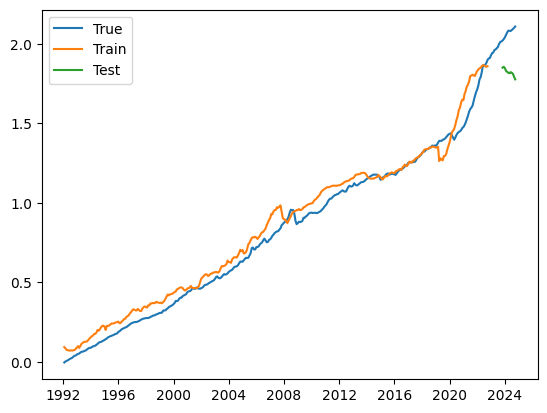

In [ ]:
# Generate predictions and plot
import matplotlib.pyplot as plt

# Plot
plt.plot(target, label='True')
plt.plot(train_pred, label='Train')
plt.plot(test_pred, label='Test')
plt.legend()
plt.show()